# Predicting police salaries in San Francisco

Kaggle recently released salary data for public servants of the city of San Francisco. Here, I take a closer look at one of the top earning departments in the city (SFPD) to see what features can help predict their salaries.

## Connecting with database, filtering and refining data

In [13]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
#Create connection to SQLite database
con= sqlite3.connect('sf_salaries.sqlite')

#Use pandas to query database
police= pd.read_sql_query('''SELECT * FROM Salaries WHERE JobTitle LIKE '%POLICE%' ''',con)

In [15]:
police.head(1)#A little messy, we'll get rid of unneplcessary columns.

,Id,EmployeeName,JobTitle,BasePay,OvertimePay,OtherPay,Benefits,TotalPay,TotalPayBenefits,Year,Notes,Agency,Status
0,2,GARY JIMENEZ,CAPTAIN III (POLICE DEPARTMENT),155966,245131.88,137811.38,,538909.28,538909.28,2011,,San Francisco,


In [16]:
#Let's see if length of title affects salary variables, we'll measure the length of titles and append list of lengths to dataframe
titles= police['JobTitle'].tolist()

titleLen= []
for i in range(0,len(titles)):
    titleLen.append(len(titles[i])-1)

lenSeries= pd.Series(titleLen) #Convert list to series
print len(police),len(lenSeries)#Doublecheck that they're the same lengths

8201 8201


In [17]:
police['TitleLen']= lenSeries#Append series to dataframe
police.head(1)

,Id,EmployeeName,JobTitle,BasePay,OvertimePay,OtherPay,Benefits,TotalPay,TotalPayBenefits,Year,Notes,Agency,Status,TitleLen
0,2,GARY JIMENEZ,CAPTAIN III (POLICE DEPARTMENT),155966,245131.88,137811.38,,538909.28,538909.28,2011,,San Francisco,,30


In [18]:
#Now we'll drop the columns/Series that are not as useful to clean up the dataset
#Year 2011 is a good place to start since it is simpler in that it has no benefits.
policeClean= police.drop(['Id','EmployeeName','Notes','Agency','Status'], axis= 1)
police2011= policeClean[policeClean['Year'] == 2011]
police2011= police2011.drop(['Year','Benefits','TotalPayBenefits'], axis=1)

In [19]:
police2011.head()

,JobTitle,BasePay,OvertimePay,OtherPay,TotalPay,TitleLen
0,CAPTAIN III (POLICE DEPARTMENT),155966,245131.88,137811.38,538909.28,30
1,CAPTAIN III (POLICE DEPARTMENT),212739,106088.18,16452.60,335279.91,30
2,CAPTAIN III (POLICE DEPARTMENT),99722,87082.62,110804.30,297608.92,30
3,"COMMANDER III, (POLICE DEPARTMENT)",198778,73478.20,13957.65,286213.86,33
4,CHIEF OF POLICE,256470,0.00,11522.18,267992.59,14


## Splitting our data and visualizing features

In [20]:
#Now let's split this into a training and test dataset to 
from sklearn.cross_validation import train_test_split

train2011, test2011 = train_test_split(police2011, test_size = 0.2)

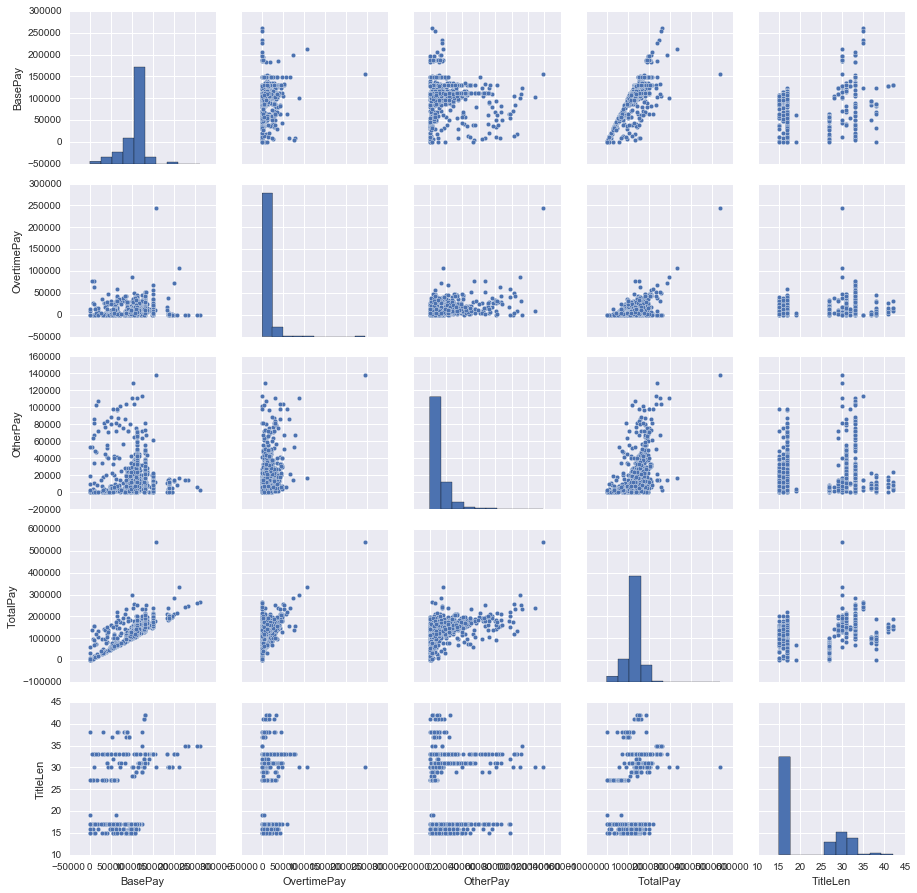

In [33]:
#Now let's see if we can identify any trends by plotting the series against one another
%matplotlib inline
sns.pairplot(train2011)

As expected, BasePay has a strong correlation with TotalPay. However, OvertimePay and OtherPay seem to have a positive correlation with TotalPay, and one outlier shows up in both. It would make sense that OvertimePay would contribute more strongly since it is more intuitive while OtherPay is a bit mysterious.

<IPython.core.display.Javascript object>


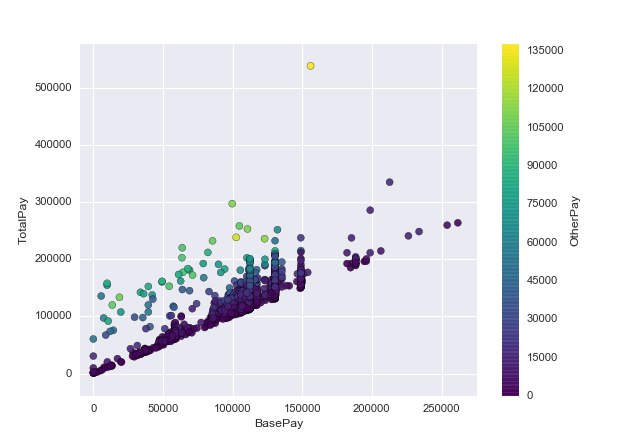

In [54]:
#Let's try to plot BasePay against TotalPay with OvertimePay on a third, colored axis
%matplotlib nbagg
train2011.plot(kind= 'scatter', x= 'BasePay',y= 'TotalPay', c= 'OtherPay',s= 40, colormap = 'viridis', alpha = 0.9)
#train2011.plot(kind= 'scatter', x= 'BasePay',y= 'TotalPay', c= 'OvertimePay',s= 40, colormap = 'viridis', alpha = 0.9)#Uses size instead of color

Interesting, although the relationship between BasePay and TotalPay is strong as expected, individuals who deviated the most from their BasePay did so through OtherPay including one individual who nearly doubled his or her BasePay from OtherPay alone. A similar plot with OvertimePay on the colored axis shows a significantly lower magnitide of values from OvertimePay).

In [23]:
train2011.describe()

,OvertimePay,OtherPay,TotalPay,TitleLen
count,2009.000000,2009.000000,2009.000000,2009.000000
mean,8970.209288,12311.065983,127207.222967,21.571926
std,10931.664453,15069.234168,37150.736574,7.371808
min,0.000000,0.000000,597.310000,15.000000
25%,2966.630000,4072.150000,114218.410000,16.000000
50%,6435.750000,7814.100000,127144.620000,17.000000
75%,11185.350000,14471.110000,146537.270000,30.000000
max,245131.880000,137811.380000,538909.280000,42.000000


## Developing our model

Now that we've cleaned up our data and have narrowed it down to a few variables, we try to determine what variables could be affecting the TotalPay of an officer. Since at best our data indicates a linear relationship, let's calculate the correlation coefficient matrix for these variables. 

In [24]:
train2011.corr()

,OvertimePay,OtherPay,TotalPay,TitleLen
OvertimePay,1.000000,0.423615,0.533378,0.152749
OtherPay,0.423615,1.000000,0.502951,0.079383
TotalPay,0.533378,0.502951,1.000000,0.261965
TitleLen,0.152749,0.079383,0.261965,1.000000


In [25]:
#We're missing BasePay. A closer inspection of the datatype reveals that BasePay and TitleLen are different datatypes than the others
train2011.dtypes

JobTitle        object
BasePay         object
OvertimePay    float64
OtherPay       float64
TotalPay       float64
TitleLen         int64
dtype: object

In [27]:
#We can change them to all be floats to include them in our analysis
train2011[['BasePay', 'TitleLen']]= train2011[['BasePay', 'TitleLen']].astype(np.float64)

In [39]:
#Let's first validate that we've changed the types
train2011.dtypes

JobTitle        object
BasePay        float64
OvertimePay    float64
OtherPay       float64
TotalPay       float64
TitleLen       float64
dtype: object

In [40]:
#Great, now we'll regenerate the correlation matrix
train2011.corr()

,BasePay,OvertimePay,OtherPay,TotalPay,TitleLen
BasePay,1.000000,0.084766,-0.034414,0.804912,0.232790
OvertimePay,0.084766,1.000000,0.423615,0.533378,0.152749
OtherPay,-0.034414,0.423615,1.000000,0.502951,0.079383
TotalPay,0.804912,0.533378,0.502951,1.000000,0.261965
TitleLen,0.232790,0.152749,0.079383,0.261965,1.000000


As expected, BasePay has a strong correlation coefficient with TotalPay and all the other variables only have at maximum 
moderately positive correlations with it. TitleLen has a weak correlation with it, but it will be helpful to know how much it contributes to predicting TotalPay. We'll add it to our model later to how much it improves the model. 

## Implementing our model with SKLearn 

In order to use our data in SKLearn, we need to convert it from dataframes to numpy arrays. We'll call TotalPay our dependent variable (y), and everything but TitleLen our independent variable (x). 

In [41]:
trainX= np.array(train2011.drop(['TitleLen','TotalPay','JobTitle'], axis= 1))
trainY= np.array(train2011['TotalPay'])

### Linear Regression

In [42]:
from sklearn import linear_model
from sklearn.metrics import r2_score

In [43]:
fitLinRegTrain= linear_model.LinearRegression()
fitLinRegTrain.fit(trainX,trainY)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [44]:
predY= fitLinRegTrain.predict(trainX)
predY

array([ 187456.7 ,  161217.88,   66786.75, ...,  163694.47,   66131.4 ,
        118252.79])

In [55]:
r2_score(trainY,predY)

1.0

That can't be correct, what's most likely occurring is that there's some dependence of OtherPay and OvertimePay on BasePay. In this situation, outliers strongly affect the R^2 and make it calculate a value approaching 1. Let's try Ridge Regression instead.

### Ridge Regression

In [59]:
fitRidgeRegTrain= linear_model.Ridge(alpha= 0.5)
fitRidgeRegTrain.fit(trainX,trainY)

Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, solver='auto', tol=0.001)

In [60]:
fitRidgeRegTrain.score

<bound method Ridge.score of Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, solver='auto', tol=0.001)>

In [61]:
fitLassoRegTrain= linear_model.Lasso(alpha= 0.5)
fitLassoRegTrain.fit(trainX,trainY)
fitLassoRegTrain.coef_

array([ 0.99999885,  1.00000604,  0.99999806])